In [1]:
import pandas as pd
import numpy as np

import os
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from cataclop.ml import preprocessing
from cataclop.ml import exploration

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 500)

from cataclop.ml.pipeline import factories

In [2]:
program = factories.Program.factory('default', version='1.1')

In [3]:
program.train(dataset_params = {
    'from': '2017-01-01',
    'to': '2020-03-01',
    'hippodrome': ['CAGNES/MER']
}, model_params = {
    'kfolds': 3,
    'nan_flag': 10000,
    'n_targets': 1
}, dataset_reload=True)

preparing model data
training xgb_10
mea: 0.3788572437181934
training xgb_100
mea: 0.27183573165244673
training ridge_0.1
mea: 0.28705445965340737
training ridge_1
mea: 0.2870503569662018
training lasso_0.1
/Users/pourquoi/.local/share/virtualenvs/cataclop-django-M9amAh3O/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
mea: 0.2889274927711761
training lasso_1
mea: 0.28871997220600476
training svr
/Users/pourquoi/.local/share/virtualenvs/cataclop-django-M9amAh3O/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
mea: 0.36525147553918724
training knn_1
mea: 0.2887913686842266
training knn_2
mea: 0.2914610764592222
training knn_5
mea: 0.2876

In [4]:
program.dataset.players.describe()

,age,earnings,final_odds,final_odds_offline,final_odds_ref,final_odds_ref_offline,final_odds_ref_unibet,final_odds_unibet,handicap_distance,handicap_weight,herder_id,horse_id,jockey_id,num,owner_id,placed_2_count,placed_3_count,placed_count,placed_dividend,placed_earnings,position,post_position,prev_year_earnings,race_count,race_id,time,trainer_id,victory_count,victory_earnings,winner_dividend,year_earnings,declared_player_count,distance,num_race,num_bis,prize,session_id,hippodrome_id,num_session,hist_1_pos,hist_2_pos,hist_3_pos,hist_4_pos,hist_5_pos,hist_6_pos,speed,win,final_odds_ref_inv,race_count_mean,race_count_std,race_count_amin,race_count_amax,hist_1_pos_mean,hist_1_pos_std,hist_1_pos_amin,hist_1_pos_amax,hist_2_pos_mean,hist_2_pos_std,hist_2_pos_amin,hist_2_pos_amax,hist_3_pos_mean,hist_3_pos_std,hist_3_pos_amin,hist_3_pos_amax,victory_count_mean,victory_count_std,victory_count_amin,victory_count_amax,placed_2_count_mean,placed_2_count_std,placed_2_count_amin,placed_2_count_amax,placed_3_count_mean,placed_3_count_std,placed_3_count_amin,placed_3_count_amax,victory_earnings_mean,victory_earnings_std,victory_earnings_amin,victory_earnings_amax,placed_earnings_mean,placed_earnings_std,placed_earnings_amin,placed_earnings_amax,prev_year_earnings_mean,prev_year_earnings_std,prev_year_earnings_amin,prev_year_earnings_amax,handicap_distance_mean,handicap_distance_std,handicap_distance_amin,handicap_distance_amax,handicap_weight_mean,handicap_weight_std,handicap_weight_amin,handicap_weight_amax,final_odds_ref_mean,final_odds_ref_std,final_odds_ref_amin,final_odds_ref_amax,final_odds_ref_offline_mean,final_odds_ref_offline_std,final_odds_ref_offline_amin,final_odds_ref_offline_amax,race_count_r,hist_1_pos_r,hist_2_pos_r,hist_3_pos_r,victory_count_r,placed_2_count_r,placed_3_count_r,victory_earnings_r,placed_earnings_r,prev_year_earnings_r,handicap_distance_r,handicap_weight_r,final_odds_ref_r,final_odds_ref_offline_r,odds_0,odds_1,odds_2,odds_3,odds_4,odds_5,odds_6,odds_7,odds_8,odds_9,odds_10,odds_11,odds_12,odds_13,odds_14,odds_15,odds_16,odds_17,odds_18,odds_19
count,21188.000000,2.118800e+04,20755.000000,14812.000000,21188.000000,21188.000000,15255.000000,15282.000000,21188.000000,21188.000000,17052.000000,21188.00000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,16944.000000,21188.000000,21188.000000,21188.000000,21188.000000,8800.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,3524.000000,21188.000000,21188.000000,21188.0,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.00000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.0
mean,5.516236,7.963922e+06,35.736502,32.867418,2986.484647,30788.626312,29.856853,32.966915,1490.769445,12.407212

In [5]:
program.model.features

['declared_player_count',
 'final_odds_ref',
 'final_odds_ref_amax',
 'final_odds_ref_amin',
 'final_odds_ref_mean',
 'final_odds_ref_offline',
 'final_odds_ref_offline_amax',
 'final_odds_ref_offline_amin',
 'final_odds_ref_offline_mean',
 'final_odds_ref_offline_r',
 'final_odds_ref_offline_std',
 'final_odds_ref_r',
 'final_odds_ref_std',
 'handicap_distance',
 'handicap_distance_amax',
 'handicap_distance_amin',
 'handicap_distance_mean',
 'handicap_distance_r',
 'handicap_distance_std',
 'handicap_weight',
 'handicap_weight_amax',
 'handicap_weight_amin',
 'handicap_weight_mean',
 'handicap_weight_r',
 'handicap_weight_std',
 'hist_1_pos',
 'hist_1_pos_amax',
 'hist_1_pos_amin',
 'hist_1_pos_mean',
 'hist_1_pos_r',
 'hist_1_pos_std',
 'hist_2_pos',
 'hist_2_pos_amax',
 'hist_2_pos_amin',
 'hist_2_pos_mean',
 'hist_2_pos_r',
 'hist_2_pos_std',
 'hist_3_pos',
 'hist_3_pos_amax',
 'hist_3_pos_amin',
 'hist_3_pos_mean',
 'hist_3_pos_r',
 'hist_3_pos_std',
 'hist_4_pos',
 'hist_5_pos',

In [6]:
program.model.models

[{'name': 'xgb_10',
  'steps': [XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
          colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
          max_depth=3, min_child_weight=1, missing=10000, n_estimators=10,
          n_jobs=1, nthread=None, objective='reg:linear', random_state=1234,
          reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
          silent=True, subsample=1)],
  'estimators': [{'pipeline': Pipeline(memory=None,
         steps=[('xgbregressor', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
           colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
           max_depth=3, min_child_weight=1, missing=10000, n_estimators=10,
           n_jobs=1, nthread=None, objective='reg:linear', random_state=1234,
           reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
           silent=True, subsample=1))]),
    'dummies': {'category': ['ATTELE',
      'PLAT',
      'HAIE',
     

save the program when the model looks good

a copy of the program, model and dataset class will be created

after locking, open the new program class in *ml/pipeline/programs* and update the ```model_params``` in the ```run``` function

In [ ]:
# program.lock('2020-03-03')

In [9]:
print(
    '{} races from {} to {}'.format(
        program.df.race_id.nunique(), 
        program.df.start_at.min(), 
        program.df.start_at.max()
    )
)

1624 races from 2017-01-05 20:15:00 to 2020-02-25 20:18:00


In [10]:
for model in program.model.models:
    clf = model['estimators'][-1]['pipeline'].steps[-1][1]
    if hasattr(clf, 'classes_'):
        clf = model['estimators'][-1]['pipeline'].steps[-1][1]
        print(clf.classes_)

In [11]:
pd.set_option('precision',7)
    
for model in program.model.models:
    clf = model['estimators'][-1]['pipeline'].steps[-1][1]
    if hasattr(clf, 'feature_importances_'):
        fi = pd.Series(clf.feature_importances_, index=program.model.features+preprocessing.get_dummy_features(model['estimators'][-1]['dummies']))
        print(model['name'])
        print(fi.sort_values(ascending=False)[0:100])
        print("---\n")
    if hasattr(clf, 'coef_'):
        fi = pd.Series(clf.coef_, index=program.model.features+preprocessing.get_dummy_features(model['estimators'][-1]['dummies']))
        print(model['name'])
        print(fi.sort_values(ascending=False)[0:100])
        print("---\n")

if hasattr(program.model, "stacked_models"):
    for model in program.model.stacked_models:
        clf = model['estimators'][-1]['pipeline'].steps[-1][1]
        if hasattr(clf, 'feature_importances_'):
            fi = pd.Series(clf.feature_importances_, index=program.model.stacked_features+preprocessing.get_dummy_features(model['estimators'][-1]['dummies']))
            print(model['name'])
            print(fi.sort_values(ascending=False)[0:100])
            print("---\n")
        if hasattr(clf, 'coef_'):
            fi = pd.Series(clf.coef_, index=program.model.stacked_features+preprocessing.get_dummy_features(model['estimators'][-1]['dummies']))
            print(model['name'])
            print(fi.sort_values(ascending=False)[0:100])
            print("---\n")
        
pd.set_option('precision',7)



xgb_10
final_odds_ref                                         0.4057971
final_odds_ref_offline                                 0.1594203
placed_2_count_r                                       0.0579710
final_odds_ref_r                                       0.0434783
final_odds_ref_offline_r                               0.0434783
final_odds_ref_amin                                    0.0434783
race_count_r                                           0.0434783
handicap_weight_std                                    0.0289855
final_odds_ref_std                                     0.0289855
odds_6                                                 0.0289855
final_odds_ref_offline_mean                            0.0144928
hist_3_pos_r                                           0.0144928
placed_3_count                                         0.0144928
placed_earnings_r                                      0.0144928
prev_year_earnings_r                                   0.0144928
placed_3_count_r  

In [12]:
df = program.df

for model in program.model.models:
    print(model['name'], df['pred_{}_1'.format(model['name'])].mean())

xgb_10 0.27707501372602017
xgb_100 0.15830278337350365
ridge_0.1 0.15733129066152118
ridge_1 0.15731379476625604
lasso_0.1 0.1571312785262436
lasso_1 0.15713930197904274
svr 0.16224847565348532
knn_1 0.1676649753890426
knn_2 0.16557805830246428
knn_5 0.16432371191091372
knn_10 0.16083851012639158
mlp_1 0.1346839771376239
mlp_10 5.140097293752091
mlp_30 -4.034775840503722
mlp_100 -8.430097844854219
rf_10 0.20473892769307958
rf_100 0.20256659598839546


In [13]:
df['pred_sum'] = df[['pred_{}_1'.format(model['name']) for model in program.model.models]].sum(axis=1)
df['pred_sum'] /= len(program.model.models)
#df['pred_sum'] = df['pred_lasso_1_1'] + df['pred_ridge_1_1'] + df['pred_rf_100_1']

In [14]:
cols = [
            'position', 
            'declared_player_count', 
            'sub_category', 
            'num', 
            'final_odds', 
            'final_odds_ref', 
            'final_odds_ref_unibet', 
            'target',
            'pred_sum'
        ] + [
            'pred_{}_1'.format(model['name']) for model in program.model.models
        ] 
exploration.random_race(df, 
                        cols=cols
                       ).sort_values(by='position', ascending=True)

position  declared_player_count sub_category  num  final_odds  \
race_id                                                                        
81408   19618       1.0                     13      INCONNU    2         3.9   
        19625       2.0                     13      INCONNU    9         8.5   
        19627       3.0                     13      INCONNU   11        10.0   
        19622       4.0                     13      INCONNU    6        55.0   
        19620       5.0                     13      INCONNU    4        16.0   
        19623       6.0                     13      INCONNU    7        36.0   
        19619       7.0                     13      INCONNU    3        21.0   
        19624       8.0                     13      INCONNU    8       176.0   
        19617       NaN                     13      INCONNU    1       147.0   
        19621       NaN                     13      INCONNU    5        10.0   
        19626       NaN                     13      INCONNU   10        22.0   
        19628       NaN                     13      INCONNU   12         5.0   
        19629       NaN                     13      INCONNU   13         5.1   

               final_odds_ref  final_odds_ref_unibet     target   pred_sum  \
race_id                                                                      
81408   19618             5.9                    6.4  1.5892352  1.0347692   
        19625            14.0                   10.2  0.0000000  1.0511779   
        19627             4.9                    8.6  0.0000000  0.9990284   
        19622            31.0                   56.8  0.0000000  1.0149711   
        19620            12.0                   21.5  0.0000000  1.2271412   
        19623            24.0                   36.7  0.0000000  1.0091093   
        19619            19.0                   10.2  0.0000000  1.0130129   
        19624            85.0                  125.8  0.0000000  0.9293142   
        19617            68.0                  119.5  0.0000000  0.9638963   
        19621             8.4                    7.8  0.0000000  1.2911629   
        19626            36.0                   36.7  0.0000000  0.9844387   
        19628             4.4                    4.7  0.0000000  1.0094688   
        19629             8.3                    3.9  0.0000000  1.0209421   

               pred_xgb_10_1  pred_xgb_100_1  pred_ridge_0.1_1  \
race_id                                                          
81408   19618      0.3840900       0.3924237         0.2557432   
        19625      0.2653810       0.1493078         0.1924076   
        19627      0.3809366       0.2802802         0.2317468   
        19622      0.2042377       0.0729459         0.1500961   
        19620      0.2998565       0.2058791         0.1732809   
        19623      0.2392216       0.0948081         0.1527561   
        19619      0.2476165       0.1508267         0.1584795   
        19624      0.1980110       0.0153002        -0.0328270   
        19617      0.1980110      -0.0225869        -0.0204424   
        19621      0.3057164       0.2428408         0.1764513   
        19626      0.2042377       0.0719838         0.1691921   
        19628      0.3904800       0.2537402         0.2452624   
        19629      0.3272158       0.2302466         0.2384354   

               pred_ridge_1_1  pred_lasso_0.1_1  pred_lasso_1_1  pred_svr_1  \
race_id                                                                       
81408   19618       0.2530230         0.1393845       0.1396003  -0.0000554   
        19625       0.1944867         0.1393717       0.1395895  -0.0003276   
        19627       0.2340019         0.1393863       0.1396022   0.0000463   
        19622       0.1522561         0.1393420       0.1395638  -0.0001202   
        19620       0.1706328         0.1393754       0.1395929  -0.0001783   
        19623       0.1550216         0.1393538       0.1395742  -0.0001748   
        19619       

In [15]:
def fast_bet(r):
    idx = r['pred_xgb_100_1'] == r['pred_xgb_100_1'].max()
    #if np.sum(idx) > 1:
    #    r['bet'] = 0
    #    return r
    r['bet'] = (idx).astype('float')
    return r
    
dd = df.groupby('race_id').filter(lambda r: r['pred_sum'].std()!=0)
dd = dd.groupby('race_id').apply(fast_bet)

In [16]:
#dd['profit'] = df['pred_xgb_10_1'] * 1 * (df['target_returns']-1)
#dd['profit'].describe()

In [17]:
df['pred_rnd'] = np.random.rand(df.shape[0])

#for model in program.model.models:
#    df['pred_minus_ref_{}'.format(model['name'])] = (-df['pred_{}_1'.format(model['name'])]-df['final_odds_ref']).pow(2).pow(0.5)
    
#for model in program.model.stacked_models:
#    df['pred_minus_ref_stacked_{}'.format(model['name'])] = (-df['pred_stacked_{}_1'.format(model['name'])]-df['final_odds_ref']).pow(2).pow(0.5)


In [18]:
#program.bet(N=1, max_odds=20, targets=['pred_rnd', 'final_odds_ref', 'pred_sum'] + ['pred_{}_1'.format(model['name']) for model in program.model.models])
#bets = program.bets
#bets['profit'].mean()

In [19]:
def bet(df, features, categorical_features, targets, N=1, max_odds=20, break_on_bet=True, break_on_odds=False):

    races = df.sort_values('start_at').groupby('race_id')

    bets = []

    for (id, race) in races:

        candidate_bets = []

        nums = []

        for target in targets:

            r = race.sort_values(by=target, ascending=False)

            if len(r) <= N:
                break
                
            NN = N

            for n in range(NN):

                player = r.iloc[n]

                odds = player['final_odds_ref']

                if max_odds is not None and odds > max_odds:
                    if break_on_odds:
                        break
                    else:
                        continue

                nth = (r['final_odds_ref']<odds).sum()+1
                
                #bet = np.clip(np.abs(player[target])/100.0, 0, 10)
                
                #bet = np.round(1+bet) * 1.5
                
                #if bet <= 0:
                #    break
                
                #if n+1 < len(r) and r.iloc[n+1][target] == player[target]:
                #    NN = NN+1
                    
                bet = 1

                profit = player['winner_dividend']/100.0 * bet - bet
                profit_placed = player['placed_dividend']/100.0 * bet - bet

                row = [id, player['start_at'], player['num'], player['position'], n, odds, player['final_odds'], target, player[target], r[target].std(), bet, profit, profit_placed]

                for nn in range(1,4):
                    if n+nn < len(r):
                        row.append(r.iloc[n+nn][target])
                    else:
                        row.append(np.nan)

                for f in features:
                    row.append(player[f])
                for f in categorical_features:
                    row.append(player[f])

                candidate_bets.append( row )

                nums.append(player['num'])

                if break_on_bet:
                    break

        #if len(candidate_bets) == 1:
        #    bets += candidate_bets
        bets += candidate_bets

    cols = ['id', 'date', 'num', 'pos', 'nb', 'odds_ref', 'odds_final', 'target', 'pred', 'pred_std', 'bet', 'profit', 'profit_placed']

    for nn in range(1,4):
        cols.append('next_pred_{}'.format(nn))

    cols = cols + features + categorical_features

    bets = pd.DataFrame(bets, columns=cols)
    bets['date'] = pd.to_datetime(bets['date'])

    bets = bets.set_index(bets['date'])
    bets = bets.sort_index()

    bets['bets'] = bets['bet'].cumsum()
    bets['stash'] = bets['profit'].cumsum()

    return bets



In [20]:

bets = bet(df, program.model.features, program.model.categorical_features, 
    N=1, max_odds=30, break_on_bet=True, break_on_odds=False, 
    targets=['pred_rnd', 'final_odds_ref', 'pred_sum'] + ['pred_{}_{}'.format(model['name'], i+1) for i in range(program.model.params['n_targets']) for model in program.model.models]# + ['pred_stacked_{}_1'.format(model['name']) for model in program.model.stacked_models] 
   )
    

In [21]:
df[['pred_{}_1'.format(model['name']) for model in program.model.models]].describe()

,pred_xgb_10_1,pred_xgb_100_1,pred_ridge_0.1_1,pred_ridge_1_1,pred_lasso_0.1_1,pred_lasso_1_1,pred_svr_1,pred_knn_1_1,pred_knn_2_1,pred_knn_5_1,pred_knn_10_1,pred_mlp_1_1,pred_mlp_10_1,pred_mlp_30_1,pred_mlp_100_1,pred_rf_10_1,pred_rf_100_1
count,20520.0000000,20520.0000000,20520.0000000,20520.0000000,20520.0000000,20520.0000000,20520.0000000,20520.0000000,20520.0000000,20520.0000000,20520.0000000,20520.0000000,20520.0000000,20520.0000000,20520.0000000,20520.0000000,20520.0000000
mean,0.2770750,0.1583028,0.1573313,0.1573138,0.1571313,0.1571393,0.1622485,0.1676650,0.1655781,0.1643237,0.1608385,0.1346840,5.1400973,-4.0347758,-8.4300978,0.2047389,0.2025666
std,0.0729380,0.1223038,0.0897723,0.0897341,0.0298684,0.0279921,0.9569380,0.5949088,0.4078602,0.2438026,0.1650863,0.0263506,135.5485538,416.7025637,216.9290486,0.2679239,0.1897905
min,0.1816342,-0.0755717,-0.2532136,-0.2496471,-0.0383052,-0.0133591,-6.3286911,0.0000000,0.0000000,0.0000000,0.0000000,-0.9392190,-1403.3995258,-1821.2523893,-4664.1079015,0.0000000,0.0000000
25%,0.2240618,0.0700604,0.1135963,0.1134862,0.1505750,0.1509756,-0.0004005,0.0000000,0.0000000,0.0000000,0.0000000,0.1310107,-0.1102048,-3.1662176,-0.4815045,0.0000000,0.0456428
50%,0.2551518,0.1280682,0.1714037,0.1714049,0.1524574,0.1529607,0.0000668,0.0000000,0.0000000,0.0000000,0.1481605,0.1332777,0.1768023,-0.0533414,0.1417950,0.0000000,0.1542652
75%,0.3161244,0.2219472,0.2162440,0.2162968,0.1535912,0.1542376,0.0008400,0.0000000,0.0000000,0.3409496,0.2587764,0.1448609,1.0497990,0.4397134,0.8362851,0.3569533,0.3126614
max,1.0003846,1.8265173,0.4243033,0.4241077,0.2923959,0.2761357,9.2165991,4.6568134,3.9412989,1.8951137,1.1039133,0.1448609,3228.7041093,14798.0395649,3330.9804507,2.0858200,2.0526660


In [22]:
bets = bets.set_index(bets['date'])
bets = bets.sort_index()

In [23]:
list(bets.columns)

['id',
 'date',
 'num',
 'pos',
 'nb',
 'odds_ref',
 'odds_final',
 'target',
 'pred',
 'pred_std',
 'bet',
 'profit',
 'profit_placed',
 'next_pred_1',
 'next_pred_2',
 'next_pred_3',
 'declared_player_count',
 'final_odds_ref',
 'final_odds_ref_amax',
 'final_odds_ref_amin',
 'final_odds_ref_mean',
 'final_odds_ref_offline',
 'final_odds_ref_offline_amax',
 'final_odds_ref_offline_amin',
 'final_odds_ref_offline_mean',
 'final_odds_ref_offline_r',
 'final_odds_ref_offline_std',
 'final_odds_ref_r',
 'final_odds_ref_std',
 'handicap_distance',
 'handicap_distance_amax',
 'handicap_distance_amin',
 'handicap_distance_mean',
 'handicap_distance_r',
 'handicap_distance_std',
 'handicap_weight',
 'handicap_weight_amax',
 'handicap_weight_amin',
 'handicap_weight_mean',
 'handicap_weight_r',
 'handicap_weight_std',
 'hist_1_pos',
 'hist_1_pos_amax',
 'hist_1_pos_amin',
 'hist_1_pos_mean',
 'hist_1_pos_r',
 'hist_1_pos_std',
 'hist_2_pos',
 'hist_2_pos_amax',
 'hist_2_pos_amin',
 'hist_2_po

In [49]:
def graph_bb(bb, f):
    results = []

    for s in bb[f].value_counts().index:
        results = []
        x = bb[ (bb[f] == s) & (bb['pred_std'] != 0) & (bb['pred'] != 0) ].copy()
        if len(x) == 0:
            continue
        #print("---\n{}\t{:+.2f}\t{:+.2f}\t{:+.2f}\n---".format(s, x['profit'].sum(), x['bet'].sum(), len(x)))

        fig, axs = plt.subplots(1,1)

        for t in x['target'].value_counts().index:
            bbb = x[(x['target'] == t)].copy()
            #bbb = bbb[ (bbb['pred']>bbb['pred'].quantile(0.85)) ].copy()


            results.append({
                'idx_1': s,
                'idx_2': t,
                'profit': bbb.profit.sum(),
                'profit_place': bbb.profit_placed.sum(),
                'bet': bbb.bet.sum(),
                'bets': bbb.bet.count(),
                'avg': bbb.profit.sum() / bbb.bet.sum()
            })

            '''
            bbb['stash'] = bbb['profit'].cumsum()
            bbb['cbet'] = bbb['bet'].cumsum()

            fig, axs = plt.subplots(1,1)
            bbb['stash'].plot(figsize=(6, 2))
            bbb['cbet'].plot(figsize=(6, 2))
            plt.show()
            '''

            #print("{:10s}: \t {:+.2f} \t {:+.0f} \t {:+.2f}".format(t, bbb.profit.sum(), bbb.profit.count(), bbb.profit.mean()) )

            bbb['stash'] = bbb['profit'].cumsum()
            bbb['cbet'] = bbb['bet'].cumsum()

            bbb['stash'].plot(figsize=(10, 2))
            #bbb['cbet'].plot(figsize=(10, 2))

        results = pd.DataFrame(results)
        results = results.set_index(['idx_1', 'idx_2'])
        print(results.sort_values(by='avg', ascending=False))


        plt.show()
        

In [25]:
countries = list(bets['country'].value_counts()[0:10].index)
sub_categories = list(bets['sub_category'].value_counts()[0:10].index)

%store countries
%store sub_categories

Stored 'countries' (list)
Stored 'sub_categories' (list)


In [26]:
from skopt.space import Real, Integer
from skopt.utils import use_named_args

target = 'pred_knn_1_1'

c_min = bets[(bets['target'] == target)]['pred'].min()
c_mean = bets[(bets['target'] == target)]['pred'].mean()
c_max = bets[(bets['target'] == target)]['pred'].max()

space = [
          Real(1, 10, name='min_odds'),
          Real(10, 60, name='max_odds'),
          Real(c_min, c_mean, name='min_pred'),
          Real(c_mean, c_max, name='max_pred'),
          Integer(5, 25, name='max_players')] + [
          Integer(0,1, name='country_{}'.format(country)) for country in countries] + [
          Integer(0,1, name='sub_category_{}'.format(sub_category)) for sub_category in sub_categories] + [
          Integer(0,1, name='nb_{}'.format(n)) for n in range(0,6)]
         
def x_to_params(x):
    params = {}
    
    params['min_odds'] = x[0]
    params['max_odds'] = x[1]
    params['max_pred'] = x[3]
    params['min_pred'] = x[2]
    params['max_players'] = x[4]
    
    for i, country in enumerate(countries):
        params['country_{}'.format(country)] = x[5+i]
        
    for i, sc in enumerate(sub_categories):
        params['sub_category_{}'.format(sc)] = x[5+len(countries)+i]
        
    for n in range(0,6):
        params['nb_{}'.format(n)] = x[5+len(countries)+len(sub_categories)+n]

    return params

@use_named_args(space)
def f(**params):
    return ff(params)
    
def ff(params, train=True):
    
    print(params)
    
    b = bets[ (bets['pred'] != 0) & (bets['target']==target) & (bets['pred_std'] != 0)]
    
    b = b[ (b['odds_ref'] > params['min_odds']) & (b['odds_ref'] < params['max_odds']) & (b['declared_player_count'] > 1) & (b['declared_player_count'] <= params['max_players']) ]
    
    #b = b[(b['pred'] >= params['min_pred']) & (b['pred'] <= params['max_pred'])]
    
    for country in countries:
        if params['country_{}'.format(country)] == 0:
            b = b[ b['country'] != country ]
            
    for sub_category in sub_categories:
        if params['sub_category_{}'.format(sub_category)] == 0:
            b = b[ b['sub_category'] != sub_category ]
            
    for n in range(0,6):
        if params['nb_{}'.format(n)] == 0:
            b = b[ b['nb'] != n]
    
    p = b.profit.sum()
    pp = len(b[b['profit'] > 0])
    bet = b.bet.sum()
    
    print("{:+.2f} {:+.2f}\n".format(p, bet))
        
    if bet == 0:
        return 0
    
    if not train:
        return b
    
    return - (p)
    
    

In [27]:
#c_mean, c_min, c_max

In [28]:
#from skopt import dummy_minimize, gp_minimize, gbrt_minimize

#res = dummy_minimize(f, space, n_calls=500)

In [29]:
#x_to_params(res.x), res.fun

In [30]:
#params = x_to_params(res.x)
#%store params
#params

In [31]:
#%store -r params
#%store -r countries
#%store -r sub_categories

In [32]:
#bb = ff(params, False)

In [57]:
bb['pred'].describe()

count      764.0000000
mean         6.2960928
std        548.3535178
min      -1818.2983006
25%         -3.4040394
50%          0.2909783
75%          0.7056522
max      13762.7791025
Name: pred, dtype: float64

                     avg  bet  bets  profit  profit_place
idx_1 idx_2                                              
FRA   pred_mlp_30_1  0.3  229   229    68.7         -32.4


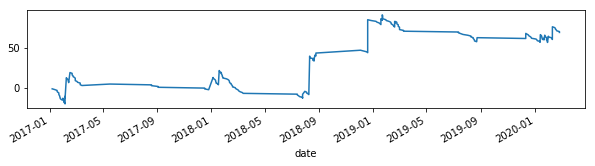

In [69]:
#bb = bets[(bets['pred'] > 1.) & (bets['next_pred_1'] != bets['next_pred_2'])]
#bb = bets[(bets['pred_std'] < 0.1) & (bets['pred'] < 1.)]
bb = bets[ (bets['odds_ref'] > 0) & (bets['target']=='pred_mlp_30_1') & (bets['pred'] < 0.5)]
#graph_bb( bb[bb['target']=='pred_knn_1_1'], 'category')
graph_bb( bb[bb['pred']>0], 'country')